In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import datetime
import os
import pickle
import scipy
import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import skies


In [3]:
run_name = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
base_runs_folder = "./runs/"
output_path = os.path.join(base_runs_folder, run_name)
mesh_parameters_file_name = "western_north_america_mesh_parameters.json"
skies.create_output_folder(base_runs_folder, output_path)
meshes = skies.read_meshes(mesh_parameters_file_name)
skies.print_magnitude_overview(meshes)


output_path='./runs/2022_10_27_21_25_29'
Read: western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

Read: cascadia.msh
Magnitude overview:
Maximum moment magnitude of entire mesh = 10.61
Maximum moment magnitude of single mesh element = 6.90
Minimum moment magnitude of single mesh element = 5.52


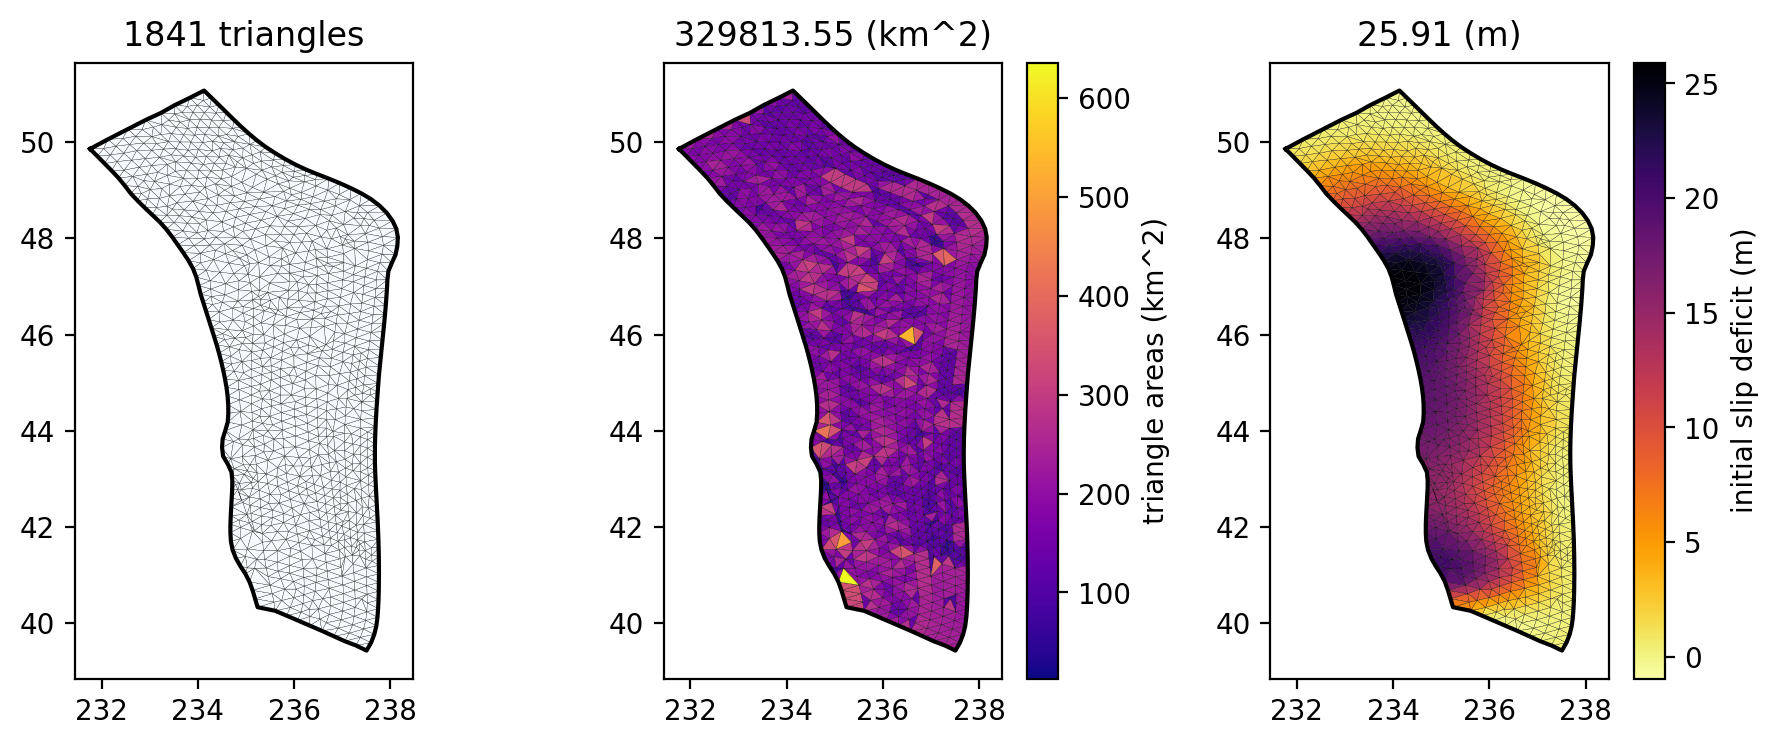

In [4]:
# Load initial slip defict and multiply by time cascadia_low_resolution_tde_dip_slip_rates.npy
initial_dip_slip_deficit = np.load("cascadia_low_resolution_tde_dip_slip_rates.npy")
total_coseismic_slip = np.zeros_like(initial_dip_slip_deficit)
skies.plot_initial_data(meshes, initial_dip_slip_deficit)


In [5]:
np.random.seed(1)


def get_omori_decay_probability(time_vector, time_of_earthquake, amplitude, decay_time):
    omori_decay_probability = amplitude / (
        1 + (1 / decay_time) * (time_vector - time_of_earthquake)
    )

    omori_decay_probability[time_vector < time_of_earthquake] = 0.0
    return omori_decay_probability


MM2M = 1e-3  # millimeters to meters
SECONDS_IN_A_YEAR = 60 * 60 * 24 * 365
DAYS_IN_A_YEAR = 365
n_years = 5000

time_vector = np.linspace(0, n_years, n_years * 1)
print(f"{time_vector.shape}")
minimum_probability = 1e-5
time_probability_weight = np.zeros_like(time_vector)
time_event = np.zeros_like(time_vector)
time_magnitude = np.zeros_like(time_vector)
time_probability = np.zeros_like(time_vector)
time_probability = minimum_probability * np.ones_like(time_vector)
new_time_probability = np.zeros_like(time_vector)
new_time_probability_asdf = np.zeros_like(time_vector)


# loading_rate = 30.0  # (mm/yr)
earthquake_index_list = []
earthquake_magnitude_list = []
earthquake_probability_list = []
event_trigger_list = []

b_value = -1.0
minimum_event_moment_magnitude = 6.0
maximum_event_moment_magnitude = 9.0

amplitude = 1e1

# Intial geometric moment and storage
mesh_geometric_moment = 1e-7 * initial_dip_slip_deficit * meshes[0].areas
pre_event_mesh_geometric_moment = np.copy(mesh_geometric_moment)

post_event_mesh_geometric_moment = np.zeros_like(mesh_geometric_moment)
mesh_geometric_moment_scalar = np.zeros_like(time_vector)
mesh_geometric_moment_scalar_non_zero = np.zeros_like(time_vector)
mesh_geometric_moment_scalar[0] = np.sum(initial_dip_slip_deficit * meshes[0].areas)

time_step = 1e-5
interseismic_loading_rate = 5e1 * initial_dip_slip_deficit
time_probability_step = 0.00005
time_probability_step = 1e-15


def get_geometric_moment_condition(event_geometric_moment, mesh_geometric_moment):
    # Case 1: Average geometric moment is grearter than zero
    if np.sum(mesh_geometric_moment) > 0:
        geometric_moment_condition = True
    else:
        geometric_moment_condition = False

    # Case 2: Accumulated geometric moment greater than or equal to

    # if event_geometric_moment < np.sum(
    #     mesh_geometric_moment[np.where(mesh_geometric_moment > 0.0)]
    # ):
    #     geometric_moment_condition = True
    #     # print(f"{event_geometric_moment[0]:0.2e}")
    #     # print(f"{np.sum(mesh_geometric_moment[np.where(mesh_geometric_moment > 0.0)]):0.2e}")
    # else:
    #     geometric_moment_condition = False
    return geometric_moment_condition


def get_tanh_probability(x, amplitude_scale_factor, data_scale_factor):
    tanh_probability = amplitude_scale_factor * np.tanh(data_scale_factor * x)
    if tanh_probability < 0:
        tanh_probability = 0
    if tanh_probability > 1:
        tanh_probability = 1
    return tanh_probability


def get_tanh_probability_vector(x, amplitude_scale_factor, data_scale_factor):
    # TODO: Fix to deal with cases where Nan's appear
    tanh_probability = amplitude_scale_factor * np.tanh(data_scale_factor * x)
    # print(np.sum(np.isfinite(tanh_probability)))
    tanh_probability[np.where(x < 0.0)] = 0.0
    # print(np.sum(np.isfinite(tanh_probability)))
    # tanh_probability[np.where(tanh_probability > 1.0)] = 1.0
    tanh_probability -= np.min(tanh_probability)
    # print(np.sum(np.isfinite(tanh_probability)))
    tanh_probability[np.isnan(tanh_probability)] = 0.0
    # print(np.sum(np.isfinite(tanh_probability)))
    tanh_probability = tanh_probability / np.sum(tanh_probability)
    # print(np.sum(np.isfinite(tanh_probability)))
    return tanh_probability


# Main time loop
for i in range(0, len(time_vector) - 1):

    # Determine whether there is an event at this time step
    amplitude_scale_factor = 1.0
    data_scale_factor = 1.0
    time_probability_weight[i] = get_tanh_probability(
        new_time_probability[i], amplitude_scale_factor, data_scale_factor
    )
    event_trigger = np.random.choice(
        2, 1, p=[1 - time_probability_weight[i], time_probability_weight[i]]
    )
    event_trigger_list.append(event_trigger)
    if event_trigger == 1:
        event = addict.Dict()
        event.shear_modulus = np.array([3e10])
        event.area_scaling = 1.25
        event.moment_magnitude = skies.get_gutenberg_richter_magnitude(
            b_value, minimum_event_moment_magnitude, maximum_event_moment_magnitude
        )
        event.moment = 10 ** (1.5 * (event.moment_magnitude + 10.7) - 7.0)
        event.geometric_moment = event.moment / event.shear_modulus
        geometric_moment_condition = get_geometric_moment_condition(
            event.geometric_moment, mesh_geometric_moment
        )
        # if geometric_moment_condition:
        if True:
            print(f"geometric moment condition is True at i={i}")
            time_event[i] = 1.0
            time_magnitude[i] = event.moment_magnitude[0]

            amplitude_scale_factor = 1.0
            data_scale_factor = 1e-5

            event.location_probability = get_tanh_probability_vector(
                pre_event_mesh_geometric_moment,
                amplitude_scale_factor,
                data_scale_factor,
            )

            event.hypocenter_triangle_index = np.random.choice(
                meshes[0].n_tde, 1, p=event.location_probability
            )[0]

            print(i)
            print("--- END EVENT GENERATION ---")
            event = skies.get_event_area_slip_triangle_index(meshes[0], event)
            print("--- START EVENT GENERATION ---")
            event.pre_event_mesh_geometric_moment = np.copy(
                pre_event_mesh_geometric_moment
            )
            event.post_event_mesh_geometric_moment = np.copy(
                pre_event_mesh_geometric_moment
                - (event.slip_all_elements * meshes[0].areas)
            )

            earthquake_magnitude_list.append(event.moment_magnitude)
            earthquake_index_list.append(i)

            # Generate Omori rate decay
            amplitude = 1e-21 * event.moment
            omori_rate_perturbation = get_omori_decay_probability(
                time_vector, time_vector[i], amplitude, decay_time=10.0
            )

            # Coseismic offset to Omori rate effect
            omori_rate_perturbation[np.where(time_vector > time_vector[i])] -= (
                amplitude / 2.0
            )

            # Store Omori rate decay
            earthquake_probability_list.append(omori_rate_perturbation)

            # Subtract event from the geometric moment mesh
            mesh_geometric_moment -= event.slip_all_elements * meshes[0].areas

            # Plot event
            # skies.plot_event(
            #     event,
            #     meshes,
            #     event.pre_event_mesh_geometric_moment,
            #     event.location_probability,
            #     event.post_event_mesh_geometric_moment,
            #     i,
            #     i,
            # )

            # Save event dictionary as pickle file
            event_pickle_file_name = f"{output_path}/event_{i:010.0f}.pickle"
            with open(event_pickle_file_name, "wb") as pickle_file:
                pickle.dump(event, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

    # Update mesh_geometric_moment
    mesh_geometric_moment += time_step * interseismic_loading_rate * meshes[0].areas
    mesh_geometric_moment_scalar[i + 1] = np.sum(mesh_geometric_moment)
    mesh_geometric_moment_scalar_non_zero[i + 1] = np.sum(
        mesh_geometric_moment[np.where(mesh_geometric_moment > 0.0)]
    )

    # Pre-event moment for next time step
    pre_event_mesh_geometric_moment = np.copy(mesh_geometric_moment)

    # Update probability
    new_time_probability[i + 1] = mesh_geometric_moment_scalar_non_zero[i + 1]
    new_time_probability_asdf[i + 1] = np.copy(new_time_probability[i + 1])

    # Sum contribution from all past earthquakes
    # TODO: The scaling factor here is magic
    for j in range(len(earthquake_index_list)):
        new_time_probability[i + 1] += 1e11 * earthquake_probability_list[j][i + 1]

    # # Catch probabilities less than zero
    # if time_probability[i + 1] < minimum_probability:
    #     time_probability[i + 1] = minimum_probability
    #     print(f"time_probability < 0.0 at step {i}")

    # # Catch probabilities greater than one
    # if time_probability[i + 1] >= 1.0:
    #     time_probability[i + 1] = 1.0
    #     print(f"time_probability > 1.0 at step {i}")


(5000,)
geometric moment condition is True at i=1
1
1841
0
--- HERE ---
geometric moment condition is True at i=2
2
1841
293
--- HERE ---
geometric moment condition is True at i=3
3
1841
811
Target area is less than hypocenter triangle area
--- HERE ---
geometric moment condition is True at i=4
4
1841
958
Target area is less than hypocenter triangle area
--- HERE ---
geometric moment condition is True at i=5
5
1841
991


/Users/meade/Desktop/skies/skies/skies.py:676: RuntimeWarning: invalid value encountered in divide
  distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(


ValueError: array must not contain infs or NaNs

In [ ]:
start_idx = 1
end_idx = 400000
figsize = (10, 1)

plt.figure(figsize=figsize)
plt.plot(
    time_vector[start_idx:end_idx],
    mesh_geometric_moment_scalar[start_idx:end_idx],
    "-r",
    linewidth=0.5,
)
plt.xlabel("time index")
plt.ylabel("$\hat{m}$")

plt.figure(figsize=figsize)
plt.plot(
    time_vector[start_idx:end_idx],
    new_time_probability[start_idx:end_idx],
    "-r",
    linewidth=0.5,
)
plt.xlabel("time index")
plt.ylabel("$p^t$")

plt.figure(figsize=figsize)
plt.plot(
    time_vector[start_idx:end_idx],
    new_time_probability_asdf[start_idx:end_idx],
    "-r",
    linewidth=0.5,
)
plt.xlabel("time index")
plt.ylabel("$p^t$ asdf")

plt.figure(figsize=figsize)
plt.plot(
    time_vector[start_idx:end_idx],
    time_magnitude[start_idx:end_idx],
    ".r",
    linewidth=0.5,
)
plt.ylim([6.5, 9.1])
plt.xlabel("time index")
plt.ylabel("event occur")
plt.show()


In [ ]:
# Probability in time: Semilogy plot
plt.figure(figsize=(10, 3))
plt.semilogy(time_vector, time_probability, "-k", linewidth=0.5, zorder=35)
fill_x = np.append(time_vector, np.array([np.max(time_vector), 0]))
fill_y = np.append(
    time_probability, np.array([minimum_probability, minimum_probability])
)
plt.fill(
    fill_x,
    fill_y,
    color="lightsteelblue",
    alpha=1.0,
    edgecolor=None,
    zorder=10,
)

cmap = cc.cm.CET_L17
magnitude_plot_size = 1e-5 * 10 ** np.array(earthquake_magnitude_list)
plt.scatter(
    time_vector[earthquake_index_list],
    time_probability[earthquake_index_list],
    s=magnitude_plot_size,
    c=earthquake_magnitude_list,
    zorder=20,
    alpha=0.65,
    cmap=cmap,
    edgecolors=None,
    linewidths=0.25,
    vmin=6.0,
    vmax=9.0,
)
cb = plt.colorbar(
    cax=plt.gca().inset_axes((0.02, 0.94, 0.15, 0.03)),
    label="magnitude",
    orientation="horizontal",
    ticks=[6, 7, 8, 9],
)
cb.ax.tick_params(labelsize=10)

plt.plot(
    time_vector[earthquake_index_list],
    time_probability[earthquake_index_list],
    ".k",
    markersize=3,
    zorder=50,
)

plt.xlabel("time index")
plt.ylabel("probability")
plt.xlim([np.min(time_vector), np.max(time_vector)])
plt.ylim([1e-4, 1])
# plt.savefig("example_probability_time_series_semilogy.pdf")
# plt.savefig("example_probability_time_series_semilogy.png", dpi=500)
plt.show()

# Earthquake magnitude plot
plt.figure(figsize=(10, 3))
for i in range(len(earthquake_index_list)):
    plt.plot(
        [time_vector[earthquake_index_list[i]], time_vector[earthquake_index_list[i]]],
        [6.0, earthquake_magnitude_list[i]],
        "-",
        # markersize=10**(earthquake_magnitude_list[i] - 6),
        linewidth=0.25,
        zorder=10,
        color="k",
    )


cmap = cc.cm.CET_L17
magnitude_plot_size = 1e-5 * 10 ** np.array(earthquake_magnitude_list)
plt.scatter(
    time_vector[earthquake_index_list],
    earthquake_magnitude_list,
    s=magnitude_plot_size,
    c=earthquake_magnitude_list,
    zorder=20,
    alpha=0.65,
    cmap=cmap,
    edgecolors=None,
    linewidths=0.25,
    vmin=6.0,
    vmax=9.0,
)

# for i in range(len(earthquake_index_list)):
#     plt.plot(
#         time_vector[earthquake_index_list[i]],
#         earthquake_magnitude_list[i],
#         ".",
#         markersize=10 ** (earthquake_magnitude_list[i] - 6),
#         # markersize=10,
#         alpha=1.0,
#         linewidth=0.0,
#         zorder=20,
#         color="orange",
#         markeredgecolor="k",
#         markeredgewidth=0.25,
#     )
plt.xlabel("time index")
plt.ylabel("magnitude")
plt.xlim([np.min(time_vector), np.max(time_vector)])
plt.ylim([6, 10])
# plt.grid(True, linewidth=0.5, linestyle="--")

# plt.savefig("example_magnitude_time_series_semilogy.pdf")
# plt.savefig("example_magnitude_time_series_semilogy.png", dpi=500)
plt.show()


In [ ]:
# def get_omori_decay_probability(time_vector, time_of_earthquake, amplitude, decay_time):
#     omori_decay_probability = amplitude / (
#         1 + (1 / decay_time) * (time_vector - time_of_earthquake)
#     )

#     omori_decay_probability[time_vector < time_of_earthquake] = 0.0
#     return omori_decay_probability


def get_omori_rate(time_vector, time_of_earthquake, productivity, decay_time, p):
    omori_rate = (
        productivity / (1 + (1 / decay_time) * (time_vector - time_of_earthquake)) ** p
    )
    omori_rate[time_vector < time_of_earthquake] = 0.0
    return omori_rate


def get_omori_productivity(
    moment_magnitude, amplitude_scale_factor, moment_magnitude_exponent
):
    omori_productivity = amplitude_scale_factor * (
        moment_magnitude**moment_magnitude_exponent
    )
    return omori_productivity


# def get_tanh_probability(x, amplitude_scale_factor, data_scale_factor):
#     tanh_probability = amplitude_scale_factor * np.tanh(data_scale_factor * x)
#     tanh_probability[np.where(x < 0.0)] = 0.0
#     tanh_probability[np.where(tanh_probability > 1.0)] = 1.0
#     return tanh_probability


n_years = 100
event_time = 20
event_moment_magnitude = 7.0

n_steps = 10000
time_index = np.linspace(0, n_years, n_steps)
event_moment = skies.moment_magnitude_to_moment(event_moment_magnitude)
loading_rate = event_moment / n_years

event_omori_productivity_amplitude_scale_factor = 0.1
event_omori_productivity_moment_magnitude_exponent = 1.0
event_omori_productivity = get_omori_productivity(
    event_moment_magnitude,
    event_omori_productivity_amplitude_scale_factor,
    event_omori_productivity_moment_magnitude_exponent,
)
event_omori_decay_time = 1.0
event_omori_exponent = 1.0
event_moment_omori_scaling = event_moment


# Loading response
ts_loading = loading_rate * time_index

# Raw Omori response
ts_omori = (
    2
    * event_moment_omori_scaling
    * get_omori_rate(
        time_index,
        event_time,
        event_omori_productivity,
        event_omori_decay_time,
        event_omori_exponent,
    )
)

# Moment deficit response
ts_eq = np.zeros_like(time_index)
ts_eq[np.where(time_index > event_time)] = -1 * event_moment

# Cumulative
ts_cumulative = ts_loading + ts_omori + ts_eq

# Probability
amplitude_scale_factor = 1e0
data_scale_factor = 1e-19
ts_probability = get_tanh_probability(
    ts_cumulative, amplitude_scale_factor, data_scale_factor
)


plt.figure(figsize=(16, 6))
n_rows = 2
n_cols = 3

plt.subplot(n_rows, n_cols, 1)
plt.plot(time_index, ts_loading, "r-")
plt.grid(True)
plt.title("loading")

plt.subplot(n_rows, n_cols, 2)
plt.plot(time_index, ts_omori, "r-")
plt.grid(True)
plt.title("Omori")

plt.subplot(n_rows, n_cols, 3)
plt.plot(time_index, ts_eq, "r-")
plt.grid(True)
plt.title("geometric moment")

plt.subplot(n_rows, n_cols, 4)
plt.plot(time_index, ts_cumulative, "r-")
plt.grid(True)
plt.title("cumulative")

plt.subplot(n_rows, n_cols, 6)
plt.plot(time_index, ts_probability, "r-")
plt.grid(True)
plt.title("probability")


In [ ]:
plt.plot(initial_dip_slip_deficit * meshes[0].areas)

In [ ]:
event.keys()

In [ ]:
len(earthquake_probability_list[0])

In [ ]:
amplitude = 1.0
ots = get_omori_decay_probability(
    time_vector, 2000, amplitude, decay_time=100.0
)

ots[np.where(time_vector > 2000)] -= (amplitude / 2.0)

plt.figure()
plt.plot(time_vector, ots)
plt.show()


In [ ]:
np.sum(np.array([True, False, False]))